In [1]:
import sys
import os
import pandas as pd
import numpy as np 
import folium   
from folium.plugins import marker_cluster
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler

sys.path.append(os.path.abspath('..')) 

from utils.preproc_utils import *
from utils.plot_utils import *

%load_ext autoreload
%autoreload 2

## **Data Import and Cleaning**

In [2]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/raw'))

basket_path = os.path.join(base_dir, 'customer_basket.csv')
customer_info_path = os.path.join(base_dir, 'customer_info.csv')
product_path = os.path.join(base_dir, 'product_mapping.xlsx')

basket = pd.read_csv(basket_path, index_col='invoice_id')
customer_info = pd.read_csv(customer_info_path, index_col='customer_id')
product = pd.read_excel(product_path)

In [3]:
customer_info_clean = clean_customer_data(customer_info)

customer_info_clean = swap_columns(customer_info_clean, 4, 6)

customer_info_clean_cont = customer_info_clean.iloc[:, 5:17]
customer_info_clean_disc = pd.concat([customer_info_clean.iloc[:, 0:5], customer_info_clean.iloc[:, 17:]], axis=1)
#customer_info_clean['city'] = customer_info_clean.apply(lambda row: assign_city(row['latitude'], row['longitude']), axis=1)
#customer_info_clean.drop(['latitude', 'longitude'], axis=1, inplace=True)

/Users/cicerosantos/Documents/GitHub/MLII/src/utils/preproc_utils.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  new_df[birthdate_column] = pd.to_datetime(new_df[birthdate_column])


In [4]:
spends = customer_info_clean_cont.columns[customer_info_clean_cont.columns.str.startswith('spend')]
spends_sums = customer_info_clean_cont.loc[:,spends].sum()
spend_labels = [f'{column_name}\n\n{value:,.0f}'.replace(",", " ") for column_name, value in zip(spends_sums.index, spends_sums.values)]

In [5]:
customer_info_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 39634 to 5120
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   kids_home                                43107 non-null  float64
 1   teens_home                               42610 non-null  float64
 2   number_complaints                        42977 non-null  float64
 3   distinct_stores_visited                  42322 non-null  float64
 4   typical_hour                             41886 non-null  float64
 5   spend_electronics                        43631 non-null  float64
 6   spend_groceries                          43631 non-null  float64
 7   spend_vegetables                         42758 non-null  float64
 8   spend_nonalcohol_drinks                  43631 non-null  float64
 9   spend_alcohol_drinks                     43631 non-null  float64
 10  spend_meat                               43631 n

## **Mapping customers**

In [6]:
# center the map at the mean coordinates
center_lat = customer_info['latitude'].mean()
center_long = customer_info['longitude'].mean()

m = folium.Map(location=[center_lat, center_long], zoom_start=6)

# due to the large number of points, we use a marker cluster
marker_cluster = MarkerCluster().add_to(m)

for idx, row in customer_info.iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(marker_cluster)

NameError: name 'MarkerCluster' is not defined

## **Distribution Analysis**

### **Continuous Variables**

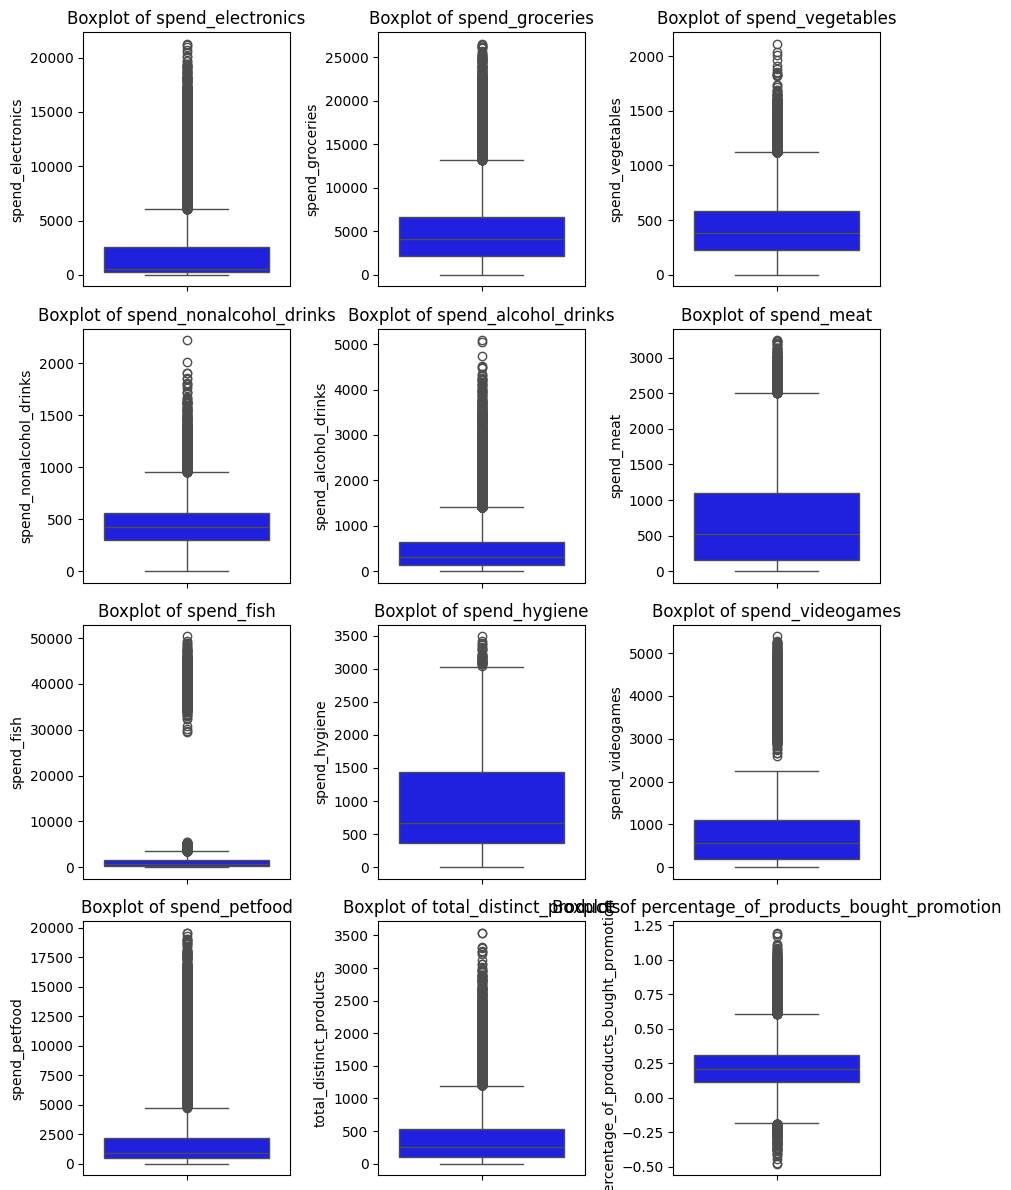

In [5]:
boxplotter(customer_info_clean_cont)

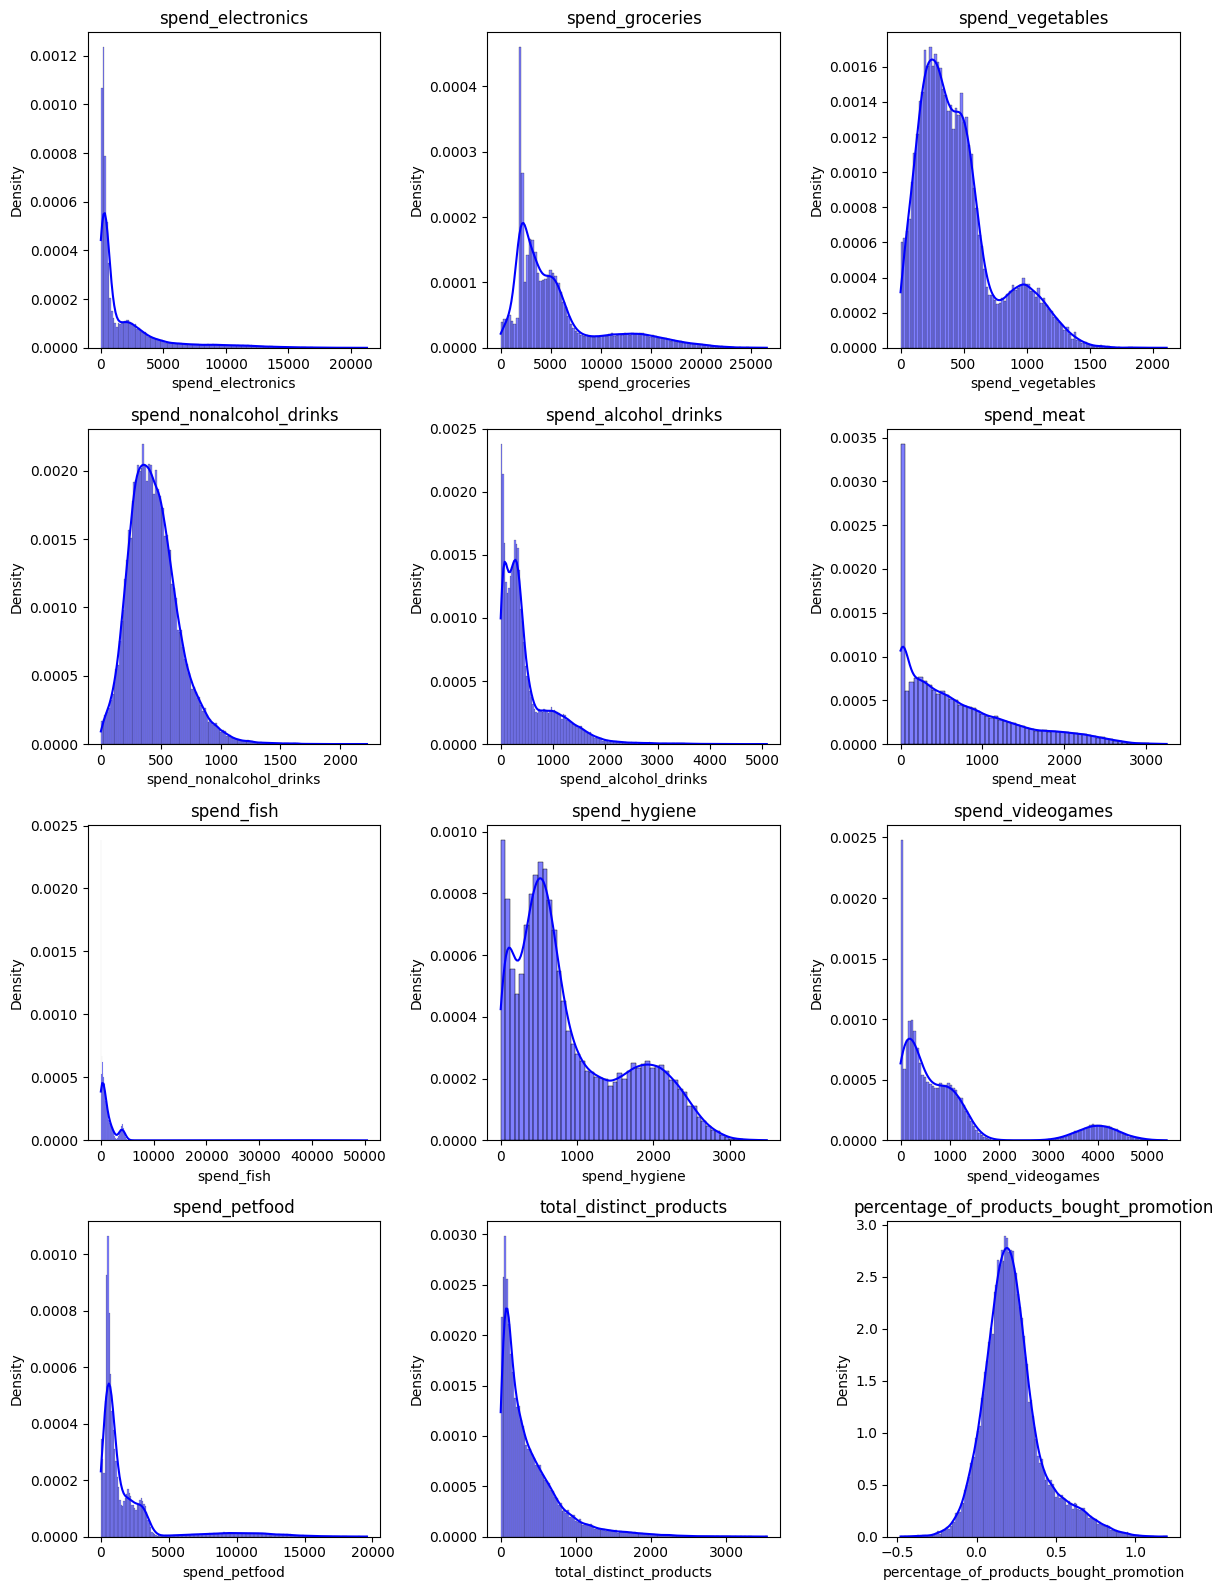

In [6]:
col_plotter(customer_info_clean_cont)

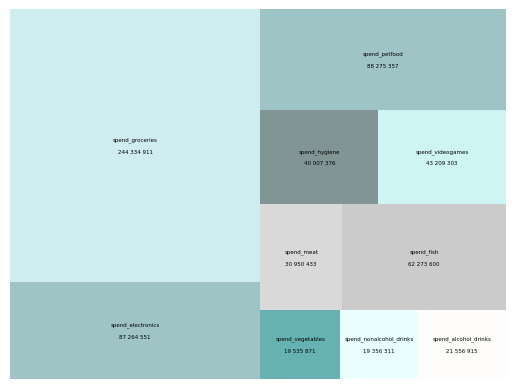

In [31]:
colors = [
    'cadetblue',
    'powderblue',
    'teal',
    'lightcyan',
    'snow',
    'silver',
    'darkgrey',
    'darkslategrey',
    'paleturquoise'
]

# Create the treemap
squarify.plot(sizes=spends_sums.values, label = spend_labels, color = colors, alpha=0.6, text_kwargs={'fontsize':4})

# Add labels
plt.axis('off')

# Display the treemap
plt.show()

### **Discrete Variables**

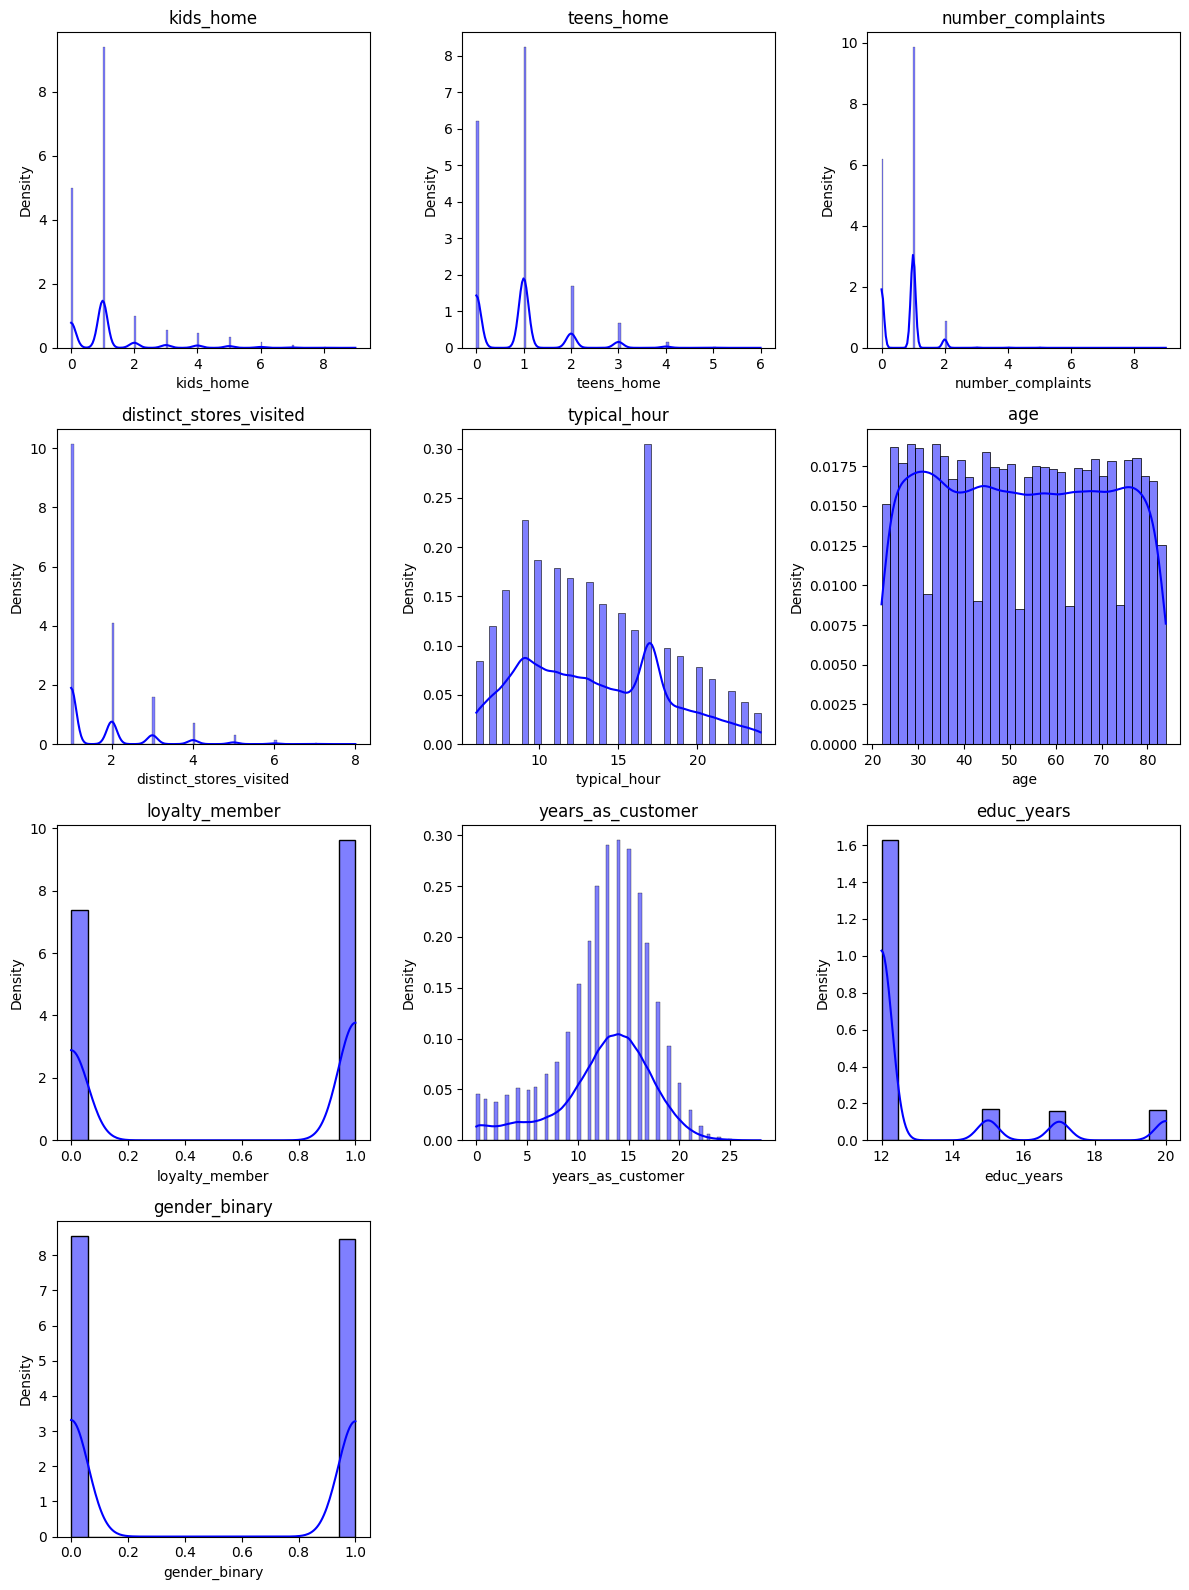

In [7]:
col_plotter(customer_info_clean_disc)

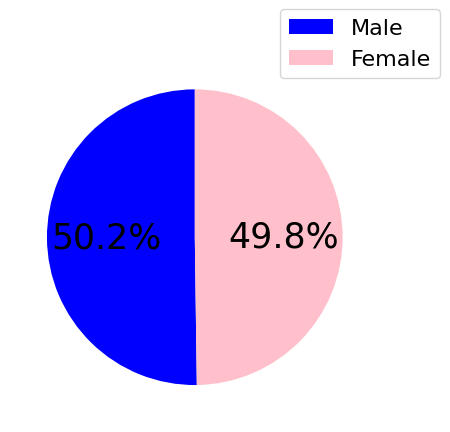

In [20]:
plot_pie_chart(customer_info_clean, 'gender_binary', colors = ['blue', 'pink'], legend = ['Male', 'Female'])

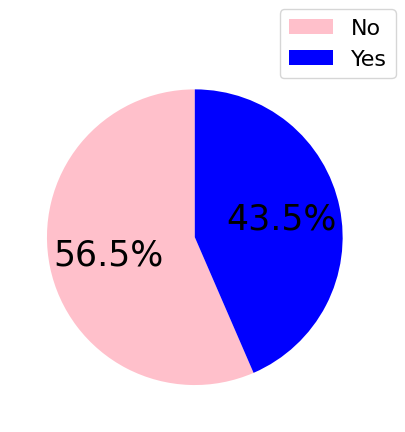

In [21]:
plot_pie_chart(customer_info_clean_disc, 'loyalty_member', colors = ['pink', 'blue'], legend = ['No', 'Yes'])

### **New Features**

In [8]:
new_features = feat_engineering(customer_info_clean_cont)
new_features = new_features.iloc[:, 2:]

/Users/cicerosantos/Documents/GitHub/MLII/src/utils/preproc_utils.py:219: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df['frequency'].fillna(0, inplace=True)


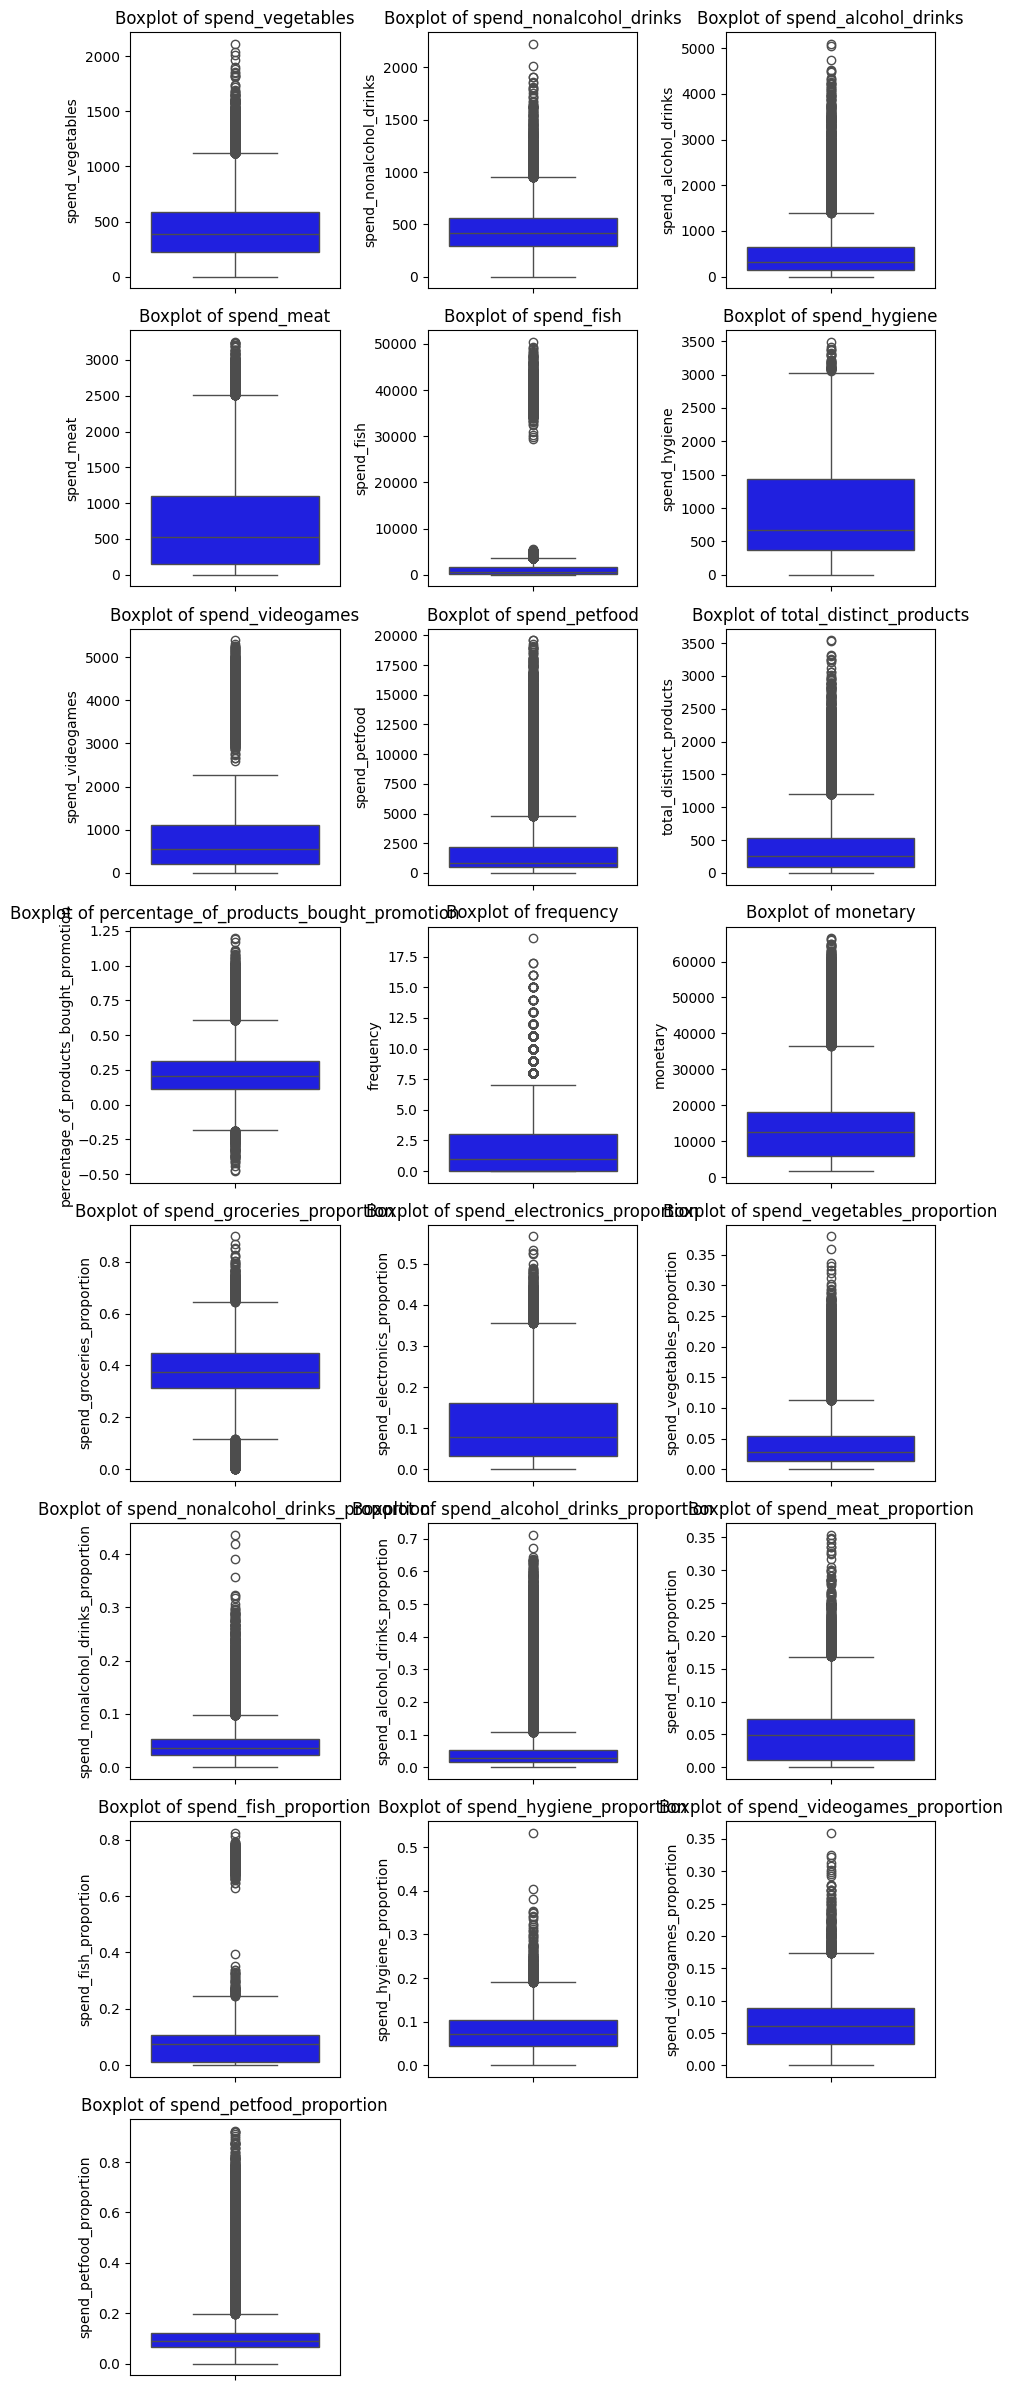

In [9]:
boxplotter(new_features)

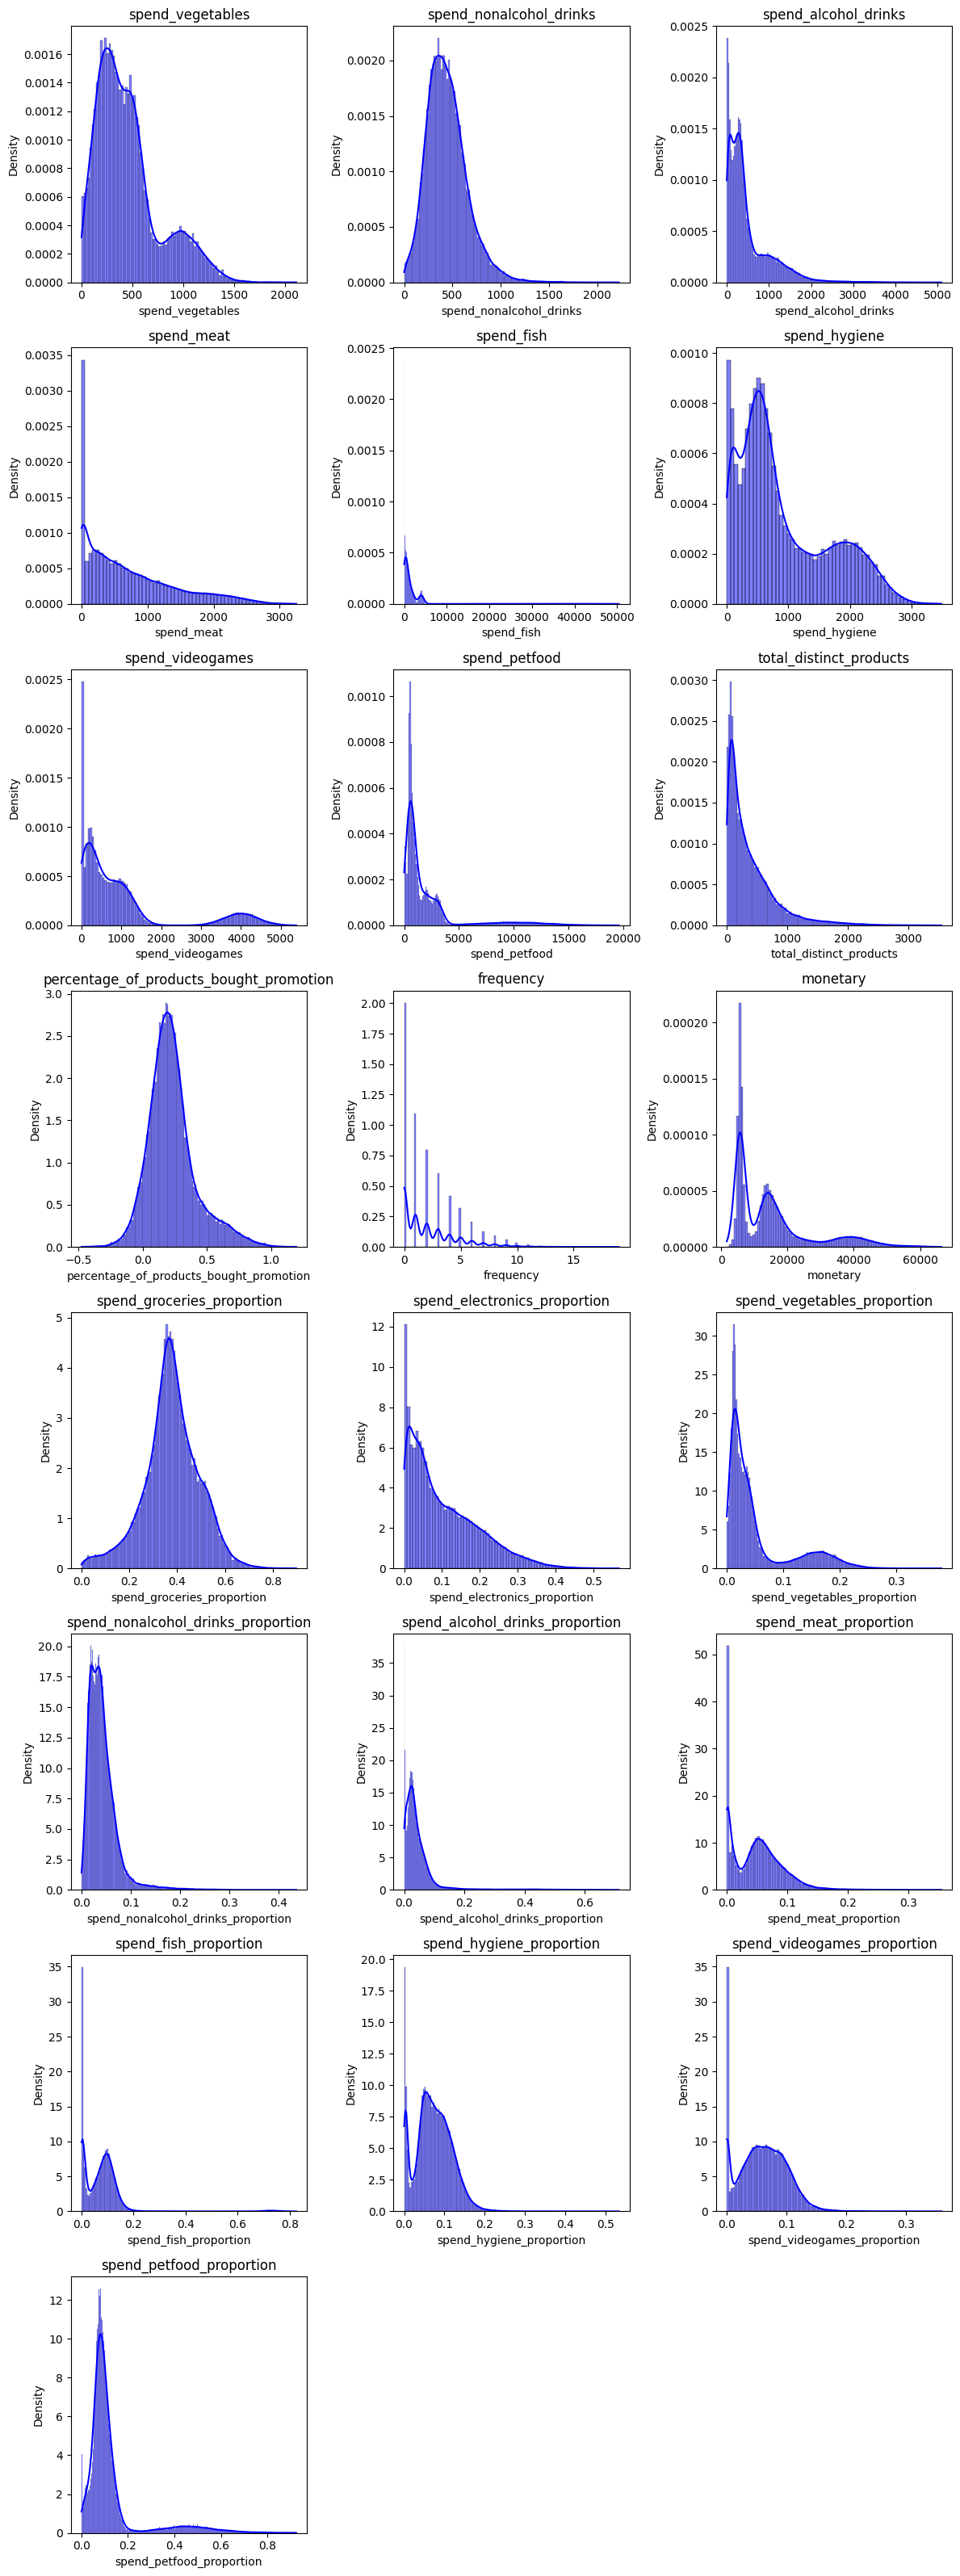

In [10]:
col_plotter(new_features)

## **Variance and Correlation Analysis**

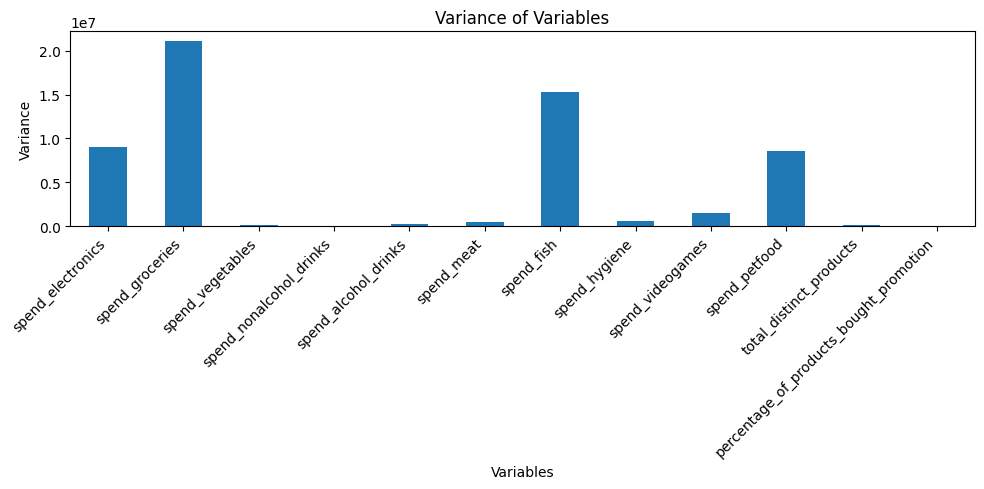

In [11]:
plot_variance(customer_info_clean_cont)

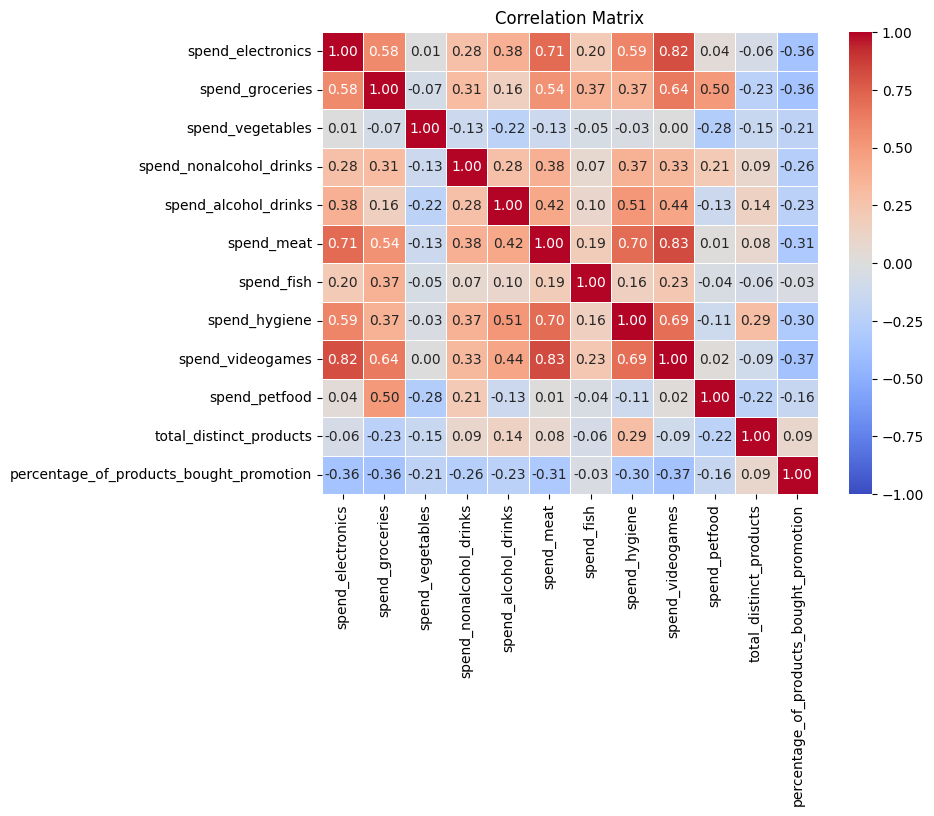

In [12]:
correlation_plotter(customer_info_clean_cont)

## **Missing Values and Inconsistency Checking**

In [13]:
basket.isna().sum()

list_of_goods    0
customer_id      0
dtype: int64

In [14]:
product.isna().sum()

product_name    0
category        0
dtype: int64

In [15]:
customer_info_clean.isna().sum()

kids_home                                   524
teens_home                                 1021
number_complaints                           654
distinct_stores_visited                    1309
typical_hour                               1745
spend_electronics                             0
spend_groceries                               0
spend_vegetables                            873
spend_nonalcohol_drinks                       0
spend_alcohol_drinks                          0
spend_meat                                    0
spend_fish                                 1309
spend_hygiene                                 0
spend_videogames                              0
spend_petfood                                 0
total_distinct_products                       0
percentage_of_products_bought_promotion       0
age                                           0
loyalty_member                                0
years_as_customer                             0
educ_years                              

In [16]:
missing_percentage_per_column = round(((customer_info_clean.isnull().sum() / len(customer_info_clean)) * 100), 2)

columns_with_missing_values = missing_percentage_per_column[missing_percentage_per_column > 0]

total_missing_percentage = (customer_info_clean.isnull().sum().sum() / (customer_info_clean.shape[0] * customer_info_clean.shape[1])) * 100

print("Percentage of missing values in each column with missing data:")
print(columns_with_missing_values)
print("\nPercentage of missing values in the entire DataFrame:", round(total_missing_percentage, 2))

Percentage of missing values in each column with missing data:
kids_home                  1.20
teens_home                 2.34
number_complaints          1.50
distinct_stores_visited    3.00
typical_hour               4.00
spend_vegetables           2.00
spend_fish                 3.00
dtype: float64

Percentage of missing values in the entire DataFrame: 0.77


### **Inconsistency Checking**


In [17]:
datasets = {
    "basket": basket,
    "customer_info_refactored": customer_info_clean,
    "product": product
}

for name, dataset in datasets.items():
    print(f"Number of duplicates removed from the {name} dataset: {dataset.duplicated().sum()}")
    dataset.drop_duplicates(inplace=True)


Number of duplicates removed from the basket dataset: 0
Number of duplicates removed from the customer_info_refactored dataset: 0
Number of duplicates removed from the product dataset: 1
